# Problem 0

Winter is coming (or rather, is here). So let's do some warm-up exercises to get you in the right mindset for the rest of the exam.

The main point of this problem is to make sure you can quickly read some Python documentation and apply it.

This problem has three (3) exercises (numbered 0-2) and is worth a total of ten (10) points.

## Setup

This problem depends on the following modules. Make sure these are available on your system before beginning.

In [2]:
import pandas as pd

from IPython.display import display

import seaborn as sns
%matplotlib inline

from scipy.cluster.vq import kmeans2

# Utility function for later on
def make_scatter_plot (df, x="x_1", y="x_2", hue="label",
                       palette={0: "red", 1: "olive", 2: "blue", 3: "green"},
                       size=5,
                       centers=None):
    from seaborn import lmplot
    from matplotlib.pyplot import scatter
    if (hue is not None) and (hue in df.columns):
        lmplot (x=x, y=y, hue=hue, data=df, palette=palette,
                fit_reg=False)
    else:
        lmplot (x=x, y=y, data=df, fit_reg=False)

    if centers is not None:
        scatter (centers[:,0], centers[:,1],
                 marker=u'*', s=500,
                 c=[palette[0], palette[1]])

import urllib
import gzip

## Download and unpack a compressed file

**Exercise 0** (4 points). Write a function that

- downloads a compressed gzip (`xxx.gz`) file from the interwebs, given its URL; and
- returns a file-like handle to it.

In particular, find and read the documentation for [`urllib.request.urlopen()`](https://docs.python.org/3/library/urllib.request.html) and [`gzip.open()`](https://docs.python.org/3/library/gzip.html), and use them to implement the desired function.

> Note: `gzip.open()` accepts an optional argument named `mode`, which specifies how to interpret the contents of the data when decompressing it. The `url_open_gz()` function you implement should simply pass its `mode` argument onto `gzip.open()`.

The test code will check your implementation and uses it to download a dataset, which you will need for the rest of this problem.

In [3]:
def open_url_gz (url_gz, mode='rt'):
    """
    Given a URL to a compressed gzip (.gz) file, downloads it to a
    temporary location, unpacks it, and returns a file-like handle
    for reading its uncompressed contents.
    """
    print ("Downloading", url_gz, "...")
    
    #
    # YOUR CODE HERE
    #
    filename=urllib.request.urlopen(url_gz)
    return gzip.open(filename, mode=mode)


In [4]:
# Test code for Part 1-A

# First, check a small message.
url_msg_gz = 'https://cse6040.gatech.edu/datasets/message_in_a_bottle.txt.gz'
with open_url_gz (url_msg_gz) as fp_msg:
    line = fp_msg.readline ()
    msg = line.strip ()
    print ("\nDownloaded the message: '%s'" % msg)
    
assert msg == 'Good luck, kiddos!'
print ("\n(Passed check 1 of 2! Sarah P., this 'pass' message is for you!)\n")

# Next, use this function to download a dataset.
url_data_gz = 'http://cse6040.gatech.edu/datasets/faithful.dat.gz'
with open_url_gz (url_data_gz) as fp:
    fp_local = open ('faithful.dat', 'wt')
    fp_local.write (fp.read ())
    fp_local.close ()
with open ('faithful.dat', 'rt') as fp_faithful:
    assert fp_faithful.readline () == 'Old Faithful Geyser Data\n'

print ("\n(Passed check 2 of 2!)")


Downloaded the message: 'Good luck, kiddos!'

(Passed check 1 of 2! Sarah P., this 'pass' message is for you!)


(Passed check 2 of 2!)


## Load the "Old Faithful" dataset

The test code above, assuming you implemented `open_url_gz()` correctly, should have downloaded and unpacked a file in the local directory called `faithful.dat`.

If you did not manage to get a working implementation that does that, then manually download a copy of this file now from here: http://www.stat.cmu.edu/~larry/all-of-statistics/=data/faithful.dat

(In either case, you should probably click on the above URL to see what is in the file, as you'll be working with this data.)

This particular dataset comes from a study of the [Old Faithful geyser](https://en.wikipedia.org/wiki/Old_Faithful) in Yellowstone National Park. Amazingly, this geyser erupts very regularly, hence the name! The dataset contains a bunch of observations, where each observation consists of a) the duration of an eruption (in minutes), and b) the time until the next eruption (again in minutes).

**Exercise 1** (2 points). Use the Pandas function, [`pd.read_table()`](http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.read_table.html), to read this dataset from `faithful.dat` and store it in a data frame with two columns, one named `eruptions` and one named `waiting`.

> Hint: There is a one-line solution, which requires only that you set the right arguments to `pd.read_table()`.

In [5]:
#
# YOUR CODE HERE
#
import pandas as pd

faithful = pd.read_table ('faithful.dat', sep='\s+', skiprows=26, names=['eruptions', 'waiting'])

# Quickly inspect this data
display (faithful.head (n=20))
print ("...")
display (faithful.tail ())

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85
6,2.883,55
7,4.700,88
8,3.600,85
9,1.950,51
10,4.350,85


...


,eruptions,waiting
268,4.117,81
269,2.150,46
270,4.417,90
271,1.817,46
272,4.467,74


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))



(Passed!)


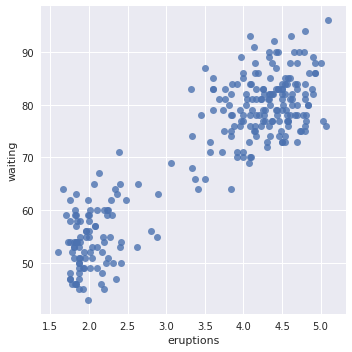

In [6]:
# Test code

make_scatter_plot (faithful, x='eruptions', y='waiting', hue=None)

# Sanity check a few values
assert set (faithful.columns) == set (['eruptions', 'waiting'])
assert sum (faithful['waiting'] == 54) == 9
assert sum (faithful['waiting'] == 90) == 6
print ("\n(Passed!)")

## Cluster this data

**Exercise 2** (2 points). The plot of the data suggests that there is a relationship between how long an eruption lasts and the time between eruptions. Use Scipy's [`kmeans2()`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.vq.kmeans2.html) to estimate this cluster structure, specifically by doing the following.

- Assign each point of `faithful` an integer cluster label that is either 0 or 1. Store these labels in a new column of the data frame named `label`.
- Compute the centers of the two clusters, storing them in a $2 \times 2$ Numpy array named `centers`, where each row `centers[i, :]` is a center whose columns contain its coordinates.

[[  4.29793023  80.28488372]
 [  2.09433     54.75      ]]
[0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 0 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 1 1 0 0 1 0 1 0]

=== Clusters ===
- Cluster 0: 172 points centered at [  4.29793023  80.28488372]
- Cluster 1: 100 points centered at [  2.09433  54.75   ]


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


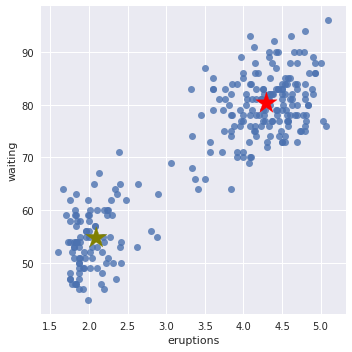

In [8]:
#
# YOUR CODE HERE
#
centers,labels=kmeans2(faithful, 2, iter=10, thresh=1e-05, minit='random', missing='warn')
print(centers)
print(labels)
num_clusters = 2
class_sizes = [sum (labels==c) for c in range (num_clusters)]
print ("\n=== Clusters ===")
for c in range (num_clusters):
    print ("- Cluster {}: {} points centered at {}".format (c,
                                                            class_sizes[c],
                                                            centers[c, :2]))

make_scatter_plot (faithful, x='eruptions', y='waiting', centers=centers)

In [26]:
assert 90 <= min (class_sizes) <= max (class_sizes) <= 180
print ("\n(Passed!)")


(Passed!)


**Fin!** If you've reached this point and all tests above pass, you are ready to submit your solution to this problem. Don't forget to save you work prior to submitting.